#PROJECT TITLE: Enhanced MRI-Based Tumor Classification with
#               EfficientNetB0 and Advanced CNN Architectures

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import plotly.graph_objects as go
import plotly.express as px
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import callbacks
import seaborn as sns
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
import tensorflow_hub as hub
import matplotlib.image as img

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = "/content/drive/MyDrive/Training"
test_dir = "/content/drive/MyDrive/Testing"
img_size = (224 , 224)
batch_size = 32

In [ ]:
#Define train_data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "int" ,
    batch_size = batch_size ,
    )

#Define Classes Names
class_names= train_data.class_names
class_names


Found 5720 files belonging to 4 classes.


['glioma', 'meningioma', 'notumor', 'pituitary']

## Explore the data


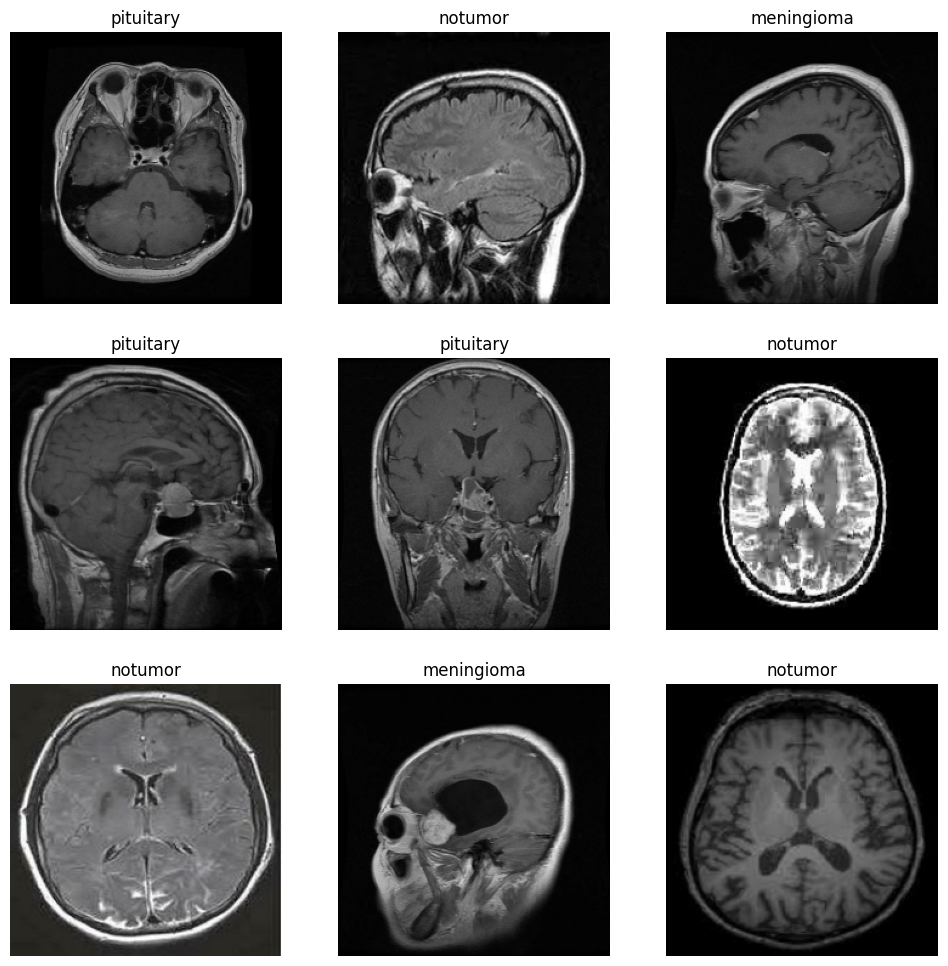

In [ ]:
# Assuming class_names is already defined and train_data is your dataset
plt.figure(figsize=(12, 12))
for images, labels in train_data.take(1):
    num_images = images.shape[0]  # Get the number of images in the batch
    num_to_display = min(9, num_images)  # Display up to 9 images or less if there are fewer images
    for i in range(num_to_display):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


# Imbalanced data Check


In [ ]:
#Deifne a Function to get number of each class samples
def each_class_samples(train_data):
    """
    taking the train data and returns the number of each class samples

    """
    #Set up counters
    meningioma = 0
    notumor = 0
    glioma = 0
    pituitary = 0

    #Looping over the train_data
    for images, labels in train_data:
        for i in range(len(images)):
            if class_names[labels[i]] == 'meningioma':
                meningioma +=1
            elif class_names[labels[i]] == 'notumor':
                notumor +=1
            elif class_names[labels[i]] == 'glioma':
                glioma +=1
            elif class_names[labels[i]] == 'pituitary':
                pituitary +=1
    print("meningioma : " + str(meningioma))
    print("glioma : " + str(glioma))
    print("notumor : " + str(notumor))
    print("pituitary : " + str(pituitary))
    return [meningioma , glioma , notumor , pituitary]

#Trying our function
meningioma  , glioma , notumor , pituitary = each_class_samples(train_data)

meningioma : 1347
glioma : 1321
notumor : 1595
pituitary : 1457


In [ ]:
# Plotting numbers of each class
fig = go.Figure(go.Bar(
            x= [meningioma,glioma,pituitary,notumor],
            y= ['meningioma','glioma','pituitary','notumor'],
            orientation='h' ,) )

fig.update_layout(title='Brain Tumor Distribution',font_size=15,title_x=0.45)


fig.show()

# Modelling_1 (Using EfficientNetB0)

## Defining Data and callBack_List


In [ ]:
#Defining some constants
img_size = (224 , 224)
batch_size = 32

#Defining train_data again
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)


#Defining Test_data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)


#Defining CallBack list

callback_list=[
    callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8,monitor="val_accuracy",patience=3)
]

Found 5720 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


## Modelling
* First Stage : BaseModel(Freezed) . add[Conv2D layer(`will help us in the segmentation part`)] . add[Global avg pooling layer] . add[Dense Layer] and train for 5 epochs
* Second Stage: BaseModel(un freeze last 10 layers) . ReCompile[and reduce learning rate by 10x]
* Last : [Apply Grad Cam Segmentation]

### **1.First Stage - Building the model**



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D

# Define Base_Model (EfficientNetB0)-> FOR FEATUREE EXTRACTION.
base_model = tf.keras.applications.EfficientNetB0(include_top=False)  # excluding the top layer
base_model.trainable = False  # Freezing the model parameters (Make its parameter not learnable)

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="Input_layer")  # Define the input layer

x = base_model(inputs)
x = Conv2D(32, 3, padding='same', activation="relu", name="Top_Conv_Layer")(x)  # Add a Conv2D layer for segmentation
x = tf.keras.layers.GlobalAveragePooling2D(name="Global_avg_Pooling_2D")(x)  # Add Global Average Pooling Layer 2D

outputs = tf.keras.layers.Dense(4,  # Because we have 4 Classes
                                activation="softmax",  # we will change it to linear when we apply segmentation
                                name="Output_layer")(x)
Model_1 = tf.keras.Model(inputs, outputs)  # Defining the model

# Compile the model
Model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Multiclass classification with one-hot labels
    optimizer=tf.keras.optimizers.Adam(),  # Adam optimizer with Learning_rate = 0.001
    metrics=['accuracy']
)

# Define train_data again with label_mode 'categorical'
img_size = (224, 224)
batch_size = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=img_size,
    label_mode='categorical',  # Ensure labels are one-hot encoded
    batch_size=batch_size,
)

# Define test_data with label_mode 'categorical'
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=img_size,
    label_mode='categorical',  # Ensure labels are one-hot encoded
    batch_size=batch_size,
)

# Define Callback list
callback_list = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.8, monitor="val_accuracy", patience=3)
]

# Fitting the model for 5 epochs
Model_1_History = Model_1.fit(train_data,
                              validation_data=test_data,
                              epochs=5,
                              verbose=1,
                              callbacks=callback_list)


Found 5720 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Epoch 1/5
179/179 [==============================] - 682s 4s/step - loss: 0.3773 - accuracy: 0.8490 - val_loss: 0.2807 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 2/5
179/179 [==============================] - 595s 3s/step - loss: 0.2018 - accuracy: 0.9255 - val_loss: 0.1703 - val_accuracy: 0.9344 - lr: 0.0010
Epoch 3/5
179/179 [==============================] - 548s 3s/step - loss: 0.1385 - accuracy: 0.9530 - val_loss: 0.1457 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/5
179/179 [==============================] - 591s 3s/step - loss: 0.1075 - accuracy: 0.9596 - val_loss: 0.3234 - val_accuracy: 0.8932 - lr: 0.0010
Epoch 5/5
179/179 [==============================] - 593s 3s/step - loss: 0.0930 - accuracy: 0.9661 - val_loss: 0.1073 - val_accuracy: 0.9550 - lr: 0.0010


## Plot loss curves

In [ ]:
#Define the function to plot loss and accuracy curves of train - valid
def plot_loss_curves(history):
    train_loss = history.history["loss"]
    val_loss = history.history['val_loss']
    train_accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    #Plot Loss
    plt.plot(epochs , train_loss , label = "Train Loss")
    plt.plot(epochs , val_loss , label = "Val Loss" )
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()
    #Plot accuracy
    plt.figure()
    plt.plot(epochs ,train_accuracy , label = "train_accuracy")
    plt.plot(epochs , val_accuracy , label = "val_accuracy" )
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

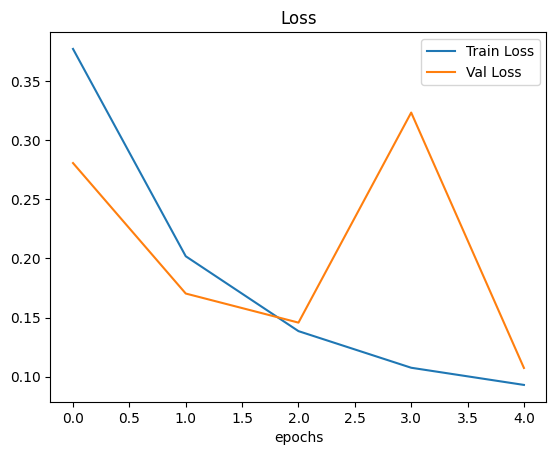

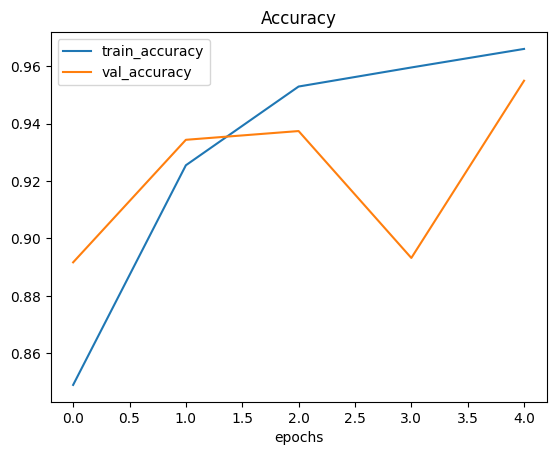

In [ ]:
#Use out function
plot_loss_curves(Model_1_History)

**Second Stage Training**
* unfreaze Last 10 Layers of the Base model
* Lower the learning rate of Adam optimizer

In [ ]:
# Define Base_Model (EfficientNetB0)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)  # excluding the top layer
base_model.trainable = True  # Unfreeze all the Base_model

# Freezing all the layers except the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="Input_layer")  # Define the input layer

x = base_model(inputs)
x = Conv2D(32, 3, padding='same', activation="relu", name="Top_Conv_Layer")(x)  # Add a Conv2D layer for segmentation
x = tf.keras.layers.GlobalAveragePooling2D(name="Global_avg_Pooling_2D")(x)  # Add Global Average Pooling Layer 2D

outputs = tf.keras.layers.Dense(4,  # Because we have 4 Classes
                                activation="softmax",  # we will change it to linear when we apply segmentation
                                name="Output_layer")(x)
Model_1 = tf.keras.Model(inputs, outputs)  # Defining the model

# Compile the model
Model_1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Use SparseCategoricalCrossentropy
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adam optimizer with lower learning rate
    metrics=["accuracy"]
)

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Define train_data again with label_mode 'int'
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=img_size,
    label_mode='int',  # Ensure labels are integer encoded
    batch_size=batch_size,
)

# Define test_data with label_mode 'int'
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=img_size,
    label_mode='int',  # Ensure labels are integer encoded
    batch_size=batch_size,
)

# Define Callback list
callback_list = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.8, monitor="val_accuracy", patience=3)
]

# Fine-tune the model for 10 epochs
initial_epoch = 5
Fine_Tune_epoch = initial_epoch + 5

# Refit the model
Stage_2_history = Model_1.fit(train_data,
                              epochs=Fine_Tune_epoch,
                              validation_data=test_data,
                              validation_steps=len(test_data),
                              initial_epoch=initial_epoch - 1,
                              verbose=1,
                              callbacks=callback_list)


Found 5720 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Epoch 5/10
179/179 [==============================] - 647s 3s/step - loss: 0.4141 - accuracy: 0.8456 - val_loss: 0.2650 - val_accuracy: 0.8947 - lr: 1.0000e-04
Epoch 6/10
179/179 [==============================] - 614s 3s/step - loss: 0.2065 - accuracy: 0.9227 - val_loss: 0.2121 - val_accuracy: 0.9176 - lr: 1.0000e-04
Epoch 7/10
179/179 [==============================] - 616s 3s/step - loss: 0.1515 - accuracy: 0.9458 - val_loss: 0.1386 - val_accuracy: 0.9443 - lr: 1.0000e-04
Epoch 8/10
179/179 [==============================] - 580s 3s/step - loss: 0.1086 - accuracy: 0.9649 - val_loss: 0.1064 - val_accuracy: 0.9641 - lr: 1.0000e-04
Epoch 9/10
179/179 [==============================] - 623s 3s/step - loss: 0.0828 - accuracy: 0.9717 - val_loss: 0.0994 - val_accuracy: 0.9641 - lr: 1.0000e-04
Epoch 10/10
179/179 [==============================] - 580s 3s/step - loss: 0.0660 - accuracy: 0.9795 - val_loss: 0.08

In [ ]:
# Recompile the model and reduce Learning rate by 10x
Model_1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # Lower the LR by 10x
    metrics=["accuracy"]
)

initial_epoch = 10
Fine_Tune_epoch = initial_epoch + 1

# Refit the model for 2 more epochs
Stage_2_history = Model_1.fit(
    train_data,
    epochs=Fine_Tune_epoch,
    validation_data=test_data,
    validation_steps=len(test_data),
    initial_epoch=initial_epoch
)


Epoch 11/11


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



179/179 [==============================] - 638s 4s/step - loss: 0.0474 - accuracy: 0.9883 - val_loss: 0.0738 - val_accuracy: 0.9703


In [ ]:
Model_1.save('/content/drive/MyDrive/mymodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



# Segmentation part Using Grad-cam


### Define some Functions

In [ ]:
#Define Some Functions :

last_conv_layer_name = "Top_Conv_Layer"

def get_img_array(img_path, size = (224 , 224)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model = Model_1 , last_conv_layer_name = last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4 , view = False):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    if view :
        display(Image(cam_path))



def decode_predictions(preds):
    classes = ['Glioma' , 'meningioma' , 'No Tumor' , 'Pituitary']
    prediction = classes[np.argmax(preds)]
    return prediction
=
def make_prediction (img_path , model = Model_1 , last_conv_layer_name = last_conv_layer_name , campath = "cam.jpeg" , view = False):
    img = get_img_array(img_path = img_path)
    img_array = get_img_array(img_path, size=(224 , 224))
    preds = Model_1.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap , cam_path=campath , view = view)
    return [campath , decode_predictions(preds)]

# Trying the segmentation on 1 MRI image


1/1 [==============================] - 7s 7s/step
meningioma


(-0.5, 317.5, 353.5, -0.5)

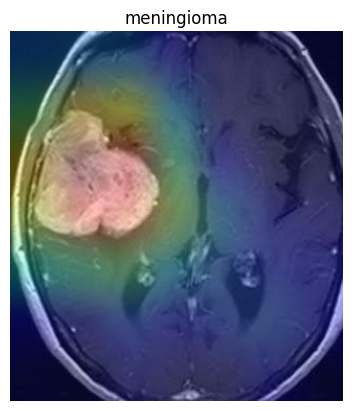

In [ ]:
campath , prediction = make_prediction("/content/drive/MyDrive/Testing/meningioma/Te-me_0025.jpg" , campath="123.jpeg" , view = False)
print(prediction)
test_img = img.imread(campath)
plt.imshow(test_img)
plt.title(prediction)
plt.axis("off")

# Trying the segmentation on MRI images


1/1 [==============================] - 0s 78ms/step


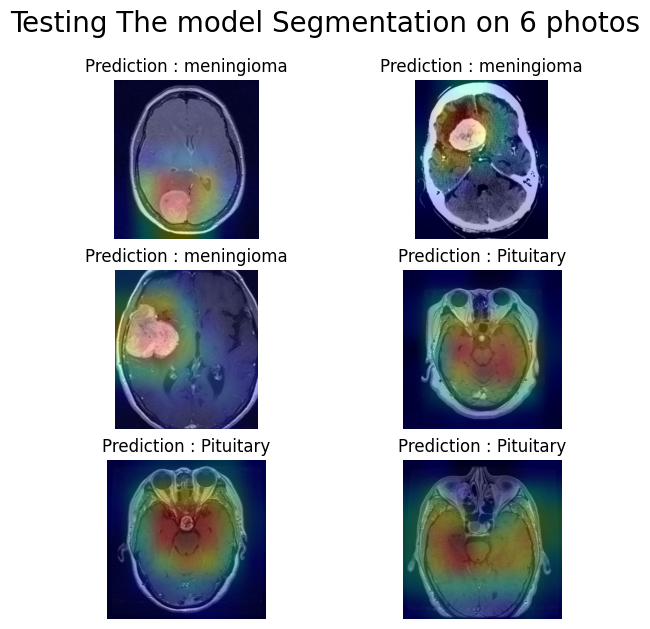

In [ ]:
#Define photos paths :
path_array = [
  '/content/drive/MyDrive/Testing/meningioma/Te-me_0010.jpg',
  '/content/drive/MyDrive/Testing/meningioma/Te-me_0015.jpg' ,
  '/content/drive/MyDrive/Testing/meningioma/Te-me_0025.jpg' ,
  '/content/drive/MyDrive/Testing/pituitary/Te-pi_0010.jpg' ,
  '/content/drive/MyDrive/Testing/pituitary/Te-pi_0021.jpg' ,
  '/content/drive/MyDrive/Testing/pituitary/Te-pi_0030.jpg' ,

]


fig = plt.figure(figsize=(7, 7))
fig.suptitle("Testing The model Segmentation on 6 photos" , fontsize = 20)
for images, labels in train_data.take(1):
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        campath , prediction = make_prediction(path_array[i] , campath=f"{i}.jpeg")
        test_img = img.imread(campath)
        plt.imshow(test_img)
        plt.title("Prediction : " + prediction)
        plt.axis("off")

In [ ]:
# Evaluate the model on the test data
results = Model_1.evaluate(test_data)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")


41/41 [==============================] - 105s 3s/step - loss: 0.0738 - accuracy: 0.9703
Test Loss: 0.07377707958221436
Test Accuracy: 97.03%
